**Introduction**

The "I’m Something of a Painter Myself" competition challenges participants to create a model capable of generating 7,000 to 10,000 Monet-style images. To address this task, a CycleGAN model was selected.

The implementation is built around four essential components:

**1- Data Preparation**

**2- Model Architecture**

**3- Loss Functions**

**4- Training Process**

Using this approach, the CycleGAN model is trained to generate Monet-style images while preserving the content of the original photos. The final outputs meet the competition’s requirements, capturing the essence of Monet’s artistic style with both realism and fidelity.

In [5]:
from google.colab import files
files.upload()  # Upload `kaggle.json`

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"esmatjafarpour","key":"b6e83665273db181801daf381473ff61"}'}

In [6]:
import os
import zipfile

# Create the Kaggle directory
os.makedirs('/root/.kaggle/', exist_ok=True)

# Copy the kaggle.json file to the Kaggle directory
!cp kaggle.json /root/.kaggle/

In [7]:
!chmod 600 /root/.kaggle/kaggle.json

In [8]:
!kaggle competitions download -c gan-getting-started

 96% 354M/367M [00:02<00:00, 177MB/s]
100% 367M/367M [00:02<00:00, 140MB/s]


In [9]:
with zipfile.ZipFile('gan-getting-started.zip', 'r') as zip_ref:
    zip_ref.extractall('gan-getting-started')

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

import PIL

AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.17.1'

**Exploratory Data Analysis**

In [11]:
TRAIN_FILES = []
TEST_FILES = []
for dirname, _, filenames in os.walk('../content/gan-getting-started/monet_tfrec'):
    for filename in filenames:
         TRAIN_FILES.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('../content/gan-getting-started/photo_tfrec'):
    for filename in filenames:
         TEST_FILES.append(os.path.join(dirname, filename))

TRAIN_FILES

['../content/gan-getting-started/monet_tfrec/monet00-60.tfrec',
 '../content/gan-getting-started/monet_tfrec/monet04-60.tfrec',
 '../content/gan-getting-started/monet_tfrec/monet12-60.tfrec',
 '../content/gan-getting-started/monet_tfrec/monet16-60.tfrec',
 '../content/gan-getting-started/monet_tfrec/monet08-60.tfrec']

In [12]:
raw_train_ds = tf.data.TFRecordDataset(TRAIN_FILES)
raw_test_ds = tf.data.TFRecordDataset(TEST_FILES)

raw_train_ds

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [13]:
import numpy as np

for raw_record in raw_train_ds.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())

    result = {}

# example.features.feature is the dictionary
for key, feature in example.features.feature.items():
    # The values are the Feature objects which contain a `kind` which contains:
    # one of three fields: bytes_list, float_list, int64_list
    kind = feature.WhichOneof('kind')
    result[key] = np.array(getattr(feature, kind).value).dtype

result

{'target': dtype('S5'), 'image_name': dtype('S10'), 'image': dtype('S36297')}

In [14]:
# Create a description of the features.
feature_description = {
    'target': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'image_name': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'image': tf.io.FixedLenFeature([], tf.string, default_value=''),
}

def _parse_image(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

train_ds = raw_train_ds.map(_parse_image)
test_ds = raw_test_ds.map(_parse_image)

train_ds

<_MapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'image_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'target': TensorSpec(shape=(), dtype=tf.string, name=None)}>

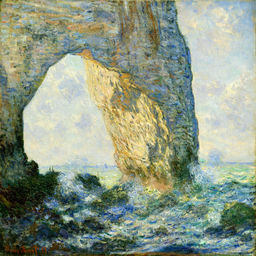

Decoded image shape: (256, 256, 3)


In [15]:
import tensorflow as tf
from IPython import display

for image_features in train_ds.take(1):  # Take one batch of data
    # Extract image and metadata
    image = image_features['image'].numpy()  # Assuming 'image' is binary JPEG data
    image_name = image_features['image_name'].numpy()
    target = image_features['target'].numpy()

    # Decode image_name (if it's a byte string)
    filename = image_name.decode('utf-8') if isinstance(image_name, bytes) else str(image_name)

    # Decode target if necessary (assuming it's a string, else skip decoding)
    label = target.decode('utf-8') if isinstance(target, bytes) else str(target)

    # Display the image
    display.display(display.Image(data=image))

    # Decode the JPEG image into a tensor
    sample_image = tf.io.decode_jpeg(image)
    print(f"Decoded image shape: {sample_image.shape}")


**Preprocessing**

In alignment with the CycleGAN framework, preprocessing techniques such as random jittering and random mirroring are applied to the training dataset.

In [16]:
# Each image is 256x256 in size
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 30

def random_crop(image):
    cropped_image = tf.image.random_crop(image, size=[IMAGE_SIZE, IMAGE_SIZE, CHANNELS])

    return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def random_jitter(image):
    # resizing to 286 x 286 x 3
    image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # randomly cropping to 256 x 256 x 3
    image = random_crop(image)

    # random mirroring
    image = tf.image.random_flip_left_right(image)

    return image

In [17]:
# The facade training set consist of 300 images
BUFFER_SIZE = 300
BATCH_SIZE = 1

def preprocess_image_train(batch):
    image = batch['image']
    image = tf.io.decode_jpeg(image, channels=CHANNELS)
    image = random_jitter(image)
    image = normalize(image)
    return image

def preprocess_image_test(batch):
    image = batch['image']
    image = tf.io.decode_jpeg(image, channels=CHANNELS)
    image = normalize(image)
    return image

def create_dataset_train(dataset):
    ds = dataset.map(lambda batch: preprocess_image_train(batch), num_parallel_calls=AUTOTUNE)
    ds = ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    return ds.prefetch(AUTOTUNE)

def create_dataset_test(dataset):
    ds = dataset.map(lambda batch: preprocess_image_test(batch), num_parallel_calls=AUTOTUNE)
    ds = ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    return ds.prefetch(AUTOTUNE)

train_ds = create_dataset_train(train_ds)
test_ds = create_dataset_test(test_ds)


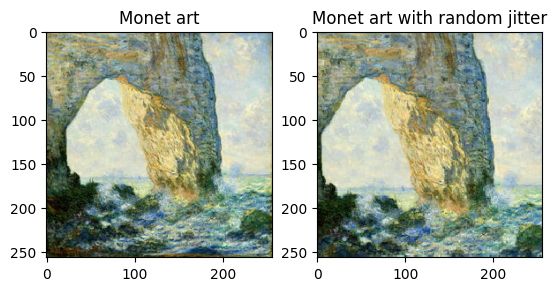

In [18]:
plt.subplot(121)
plt.title('Monet art')
plt.imshow(sample_image)

plt.subplot(122)
plt.title('Monet art with random jitter')
plt.imshow(random_jitter(sample_image))

**Constructing the CycleGAN Model**

Generator Development

The original CycleGAN paper implements a generator based on a modified ResNet architecture. However, for simplicity, a modified U-Net architecture will be utilized in this case. The U-Net structure comprises two main components: a downsampler (encoder) and an upsampler (decoder).

In [19]:
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = models.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_norm:
        result.add(layers.GroupNormalization(groups=-1))
    result.add(layers.LeakyReLU())
    return result

In [20]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = models.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    result.add(layers.GroupNormalization(groups=-1))
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

In [21]:
def make_generator():
    inputs = layers.Input(shape=[IMAGE_SIZE, IMAGE_SIZE, CHANNELS])

    down_stack = [
        downsample(64, 4, apply_norm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same',
                                  kernel_initializer=initializer, activation='tanh')

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)
    return models.Model(inputs=inputs, outputs=x)

In [22]:
def make_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inputs = layers.Input(shape=[IMAGE_SIZE, IMAGE_SIZE, 3], name='input_image')

    x = inputs
    x = downsample(64, 4, False)(x)
    x = downsample(128, 4)(x)
    x = downsample(256, 4)(x)
    x = layers.ZeroPadding2D()(x)
    x = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(x)
    x = layers.GroupNormalization(groups=-1)(x)
    x = layers.LeakyReLU()(x)
    x = layers.ZeroPadding2D()(x)
    x = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x)
    return models.Model(inputs=inputs, outputs=x)

In [23]:
monet_generator = make_generator()
photo_generator = make_generator()
monet_discriminator = make_discriminator()
photo_discriminator = make_discriminator()

**Define the loss and optimizers**

In [25]:
# Loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [24]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss * 0.5

In [26]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [27]:
LAMBDA = 10

def compute_cycle_loss(real_img, cycled_img):
    loss = tf.reduce_mean(tf.abs(real_img - cycled_img))
    return LAMBDA * loss

In [28]:
def identity_loss(real_img, same_img):
    loss = tf.reduce_mean(tf.abs(real_img - same_img))
    return LAMBDA * 0.5 * loss

In [29]:
from tensorflow.keras import optimizers

# Optimizers
monet_generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
monet_discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)

**Checkpoints**

In [30]:
CHECKPOINT_DIR = '../working/checkpoints/train'

ckpt = tf.train.Checkpoint(monet_generator=monet_generator,
                           photo_generator=photo_generator,
                           monet_discriminator=monet_discriminator,
                           photo_discriminator=photo_discriminator,
                           monet_generator_optimizer=monet_generator_optimizer,
                           photo_generator_optimizer=photo_generator_optimizer,
                           monet_discriminator_optimizer=monet_discriminator_optimizer,
                           photo_discriminator_optimizer=photo_discriminator_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, CHECKPOINT_DIR, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

**Training**

**Training Loop**

The training loop involves the following four essential steps:

- Generate Predictions: Obtain output values from the model based on the input data.
- Evaluate Loss: Measure the difference between the predicted and actual values using loss functions.
- Compute Gradients: Determine the gradients by performing backpropagation through the network.
- Update Weights: Use the optimizer to adjust the model's weights based on the calculated gradients.

In [31]:
@tf.function
def train_step(real_monet, real_photo):
    with tf.GradientTape(persistent=True) as tape:
        # real monet -> fake photo
        fake_photo = monet_generator(real_monet, training=True)
        # fake photo -> monet
        cycled_monet = photo_generator(fake_photo, training=True)
        # real photo -> fake monet
        fake_monet = photo_generator(real_photo, training=True)
        # fake monet -> photo
        cycled_photo = monet_generator(fake_monet, training=True)
        # use for identity loss
        same_monet = monet_generator(real_monet, training=True)
        same_photo = photo_generator(real_photo, training=True)

        # The discriminators evaluate both real and fake images in each domain
        disc_real_monet = monet_discriminator(real_monet, training=True)
        disc_real_photo = photo_discriminator(real_photo, training=True)
        disc_fake_monet = monet_discriminator(fake_monet, training=True)
        disc_fake_photo = photo_discriminator(fake_photo, training=True)

        # Generator losses: How well the generators fool the discriminators
        monet_gen_loss = generator_loss(disc_fake_photo)
        photo_gen_loss = generator_loss(disc_fake_monet)
        # Cycle consistency loss: Ensures that cycled images are similar to originals
        total_cycle_loss = compute_cycle_loss(real_monet, cycled_monet) + compute_cycle_loss(real_photo, cycled_photo)
        # Identity loss: Encourages generators to preserve input when it's already in the target domain
        total_monet_gen_loss = monet_gen_loss + total_cycle_loss + identity_loss(real_monet, same_monet)
        total_photo_gen_loss = photo_gen_loss + total_cycle_loss + identity_loss(real_photo, same_photo)
        # Discriminator losses: How well the discriminators distinguish real from fake images
        monet_disc_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
        photo_disc_loss = discriminator_loss(disc_real_photo, disc_fake_photo)

    # Computes the gradients for each model with respect to its loss.
    monet_generator_gradients = tape.gradient(total_monet_gen_loss, monet_generator.trainable_variables)
    photo_generator_gradients = tape.gradient(total_photo_gen_loss, photo_generator.trainable_variables)
    monet_discriminator_gradients = tape.gradient(monet_disc_loss, monet_discriminator.trainable_variables)
    photo_discriminator_gradients = tape.gradient(photo_disc_loss, photo_discriminator.trainable_variables)

    # Updates the model parameters using the calculated gradients.
    monet_generator_optimizer.apply_gradients(zip(monet_generator_gradients, monet_generator.trainable_variables))
    photo_generator_optimizer.apply_gradients(zip(photo_generator_gradients, photo_generator.trainable_variables))
    monet_discriminator_optimizer.apply_gradients(zip(monet_discriminator_gradients, monet_discriminator.trainable_variables))
    photo_discriminator_optimizer.apply_gradients(zip(photo_discriminator_gradients, photo_discriminator.trainable_variables))

In [32]:
from IPython.display import clear_output

def train(monet_dataset, photo_dataset, epochs):
    n = 0
    for epoch in range(epochs):
        start = time.time()
        for monet_image, photo_image in tf.data.Dataset.zip((monet_dataset, photo_dataset)):
            train_step(monet_image, photo_image)
            if n % 10 == 0:
                print ('.', end='')
            n += 1
        clear_output(wait=True)
        if (epoch + 1) % 5 == 0:
            ckpt_save_path = ckpt_manager.save()
            print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))

        print(f'Time taken for epoch {epoch + 1} is {time.time() - start} sec')

In [33]:
def generate_images(model, test_input):
    prediction = model(test_input)
    plt.figure(figsize=(12, 12))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Monet-style Image']
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [ ]:
# Train the model
train(train_ds, test_ds, epochs=EPOCHS)

..............................Time taken for epoch 1 is 2908.2543144226074 sec
..............................Time taken for epoch 2 is 2819.9110944271088 sec
................

**Results**

Generate Monet-style Images

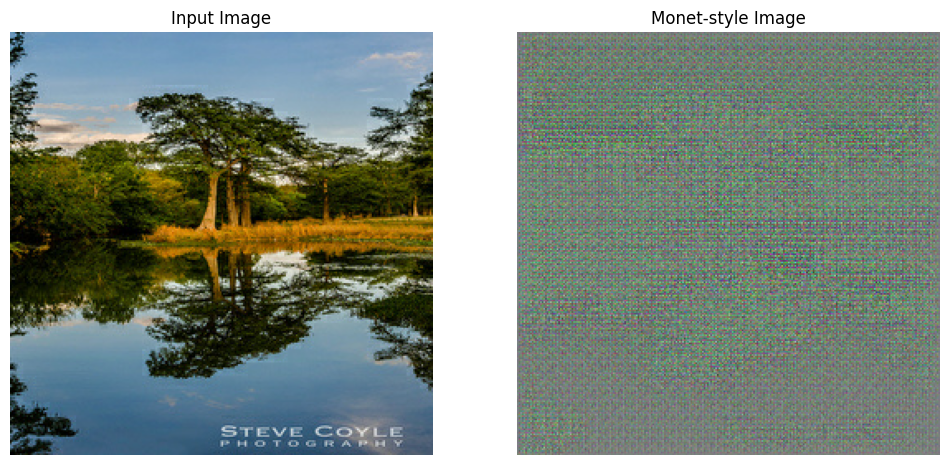

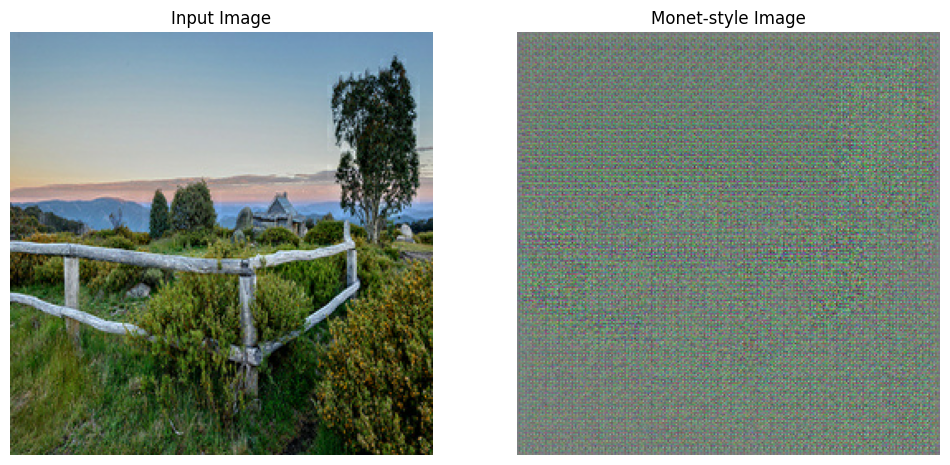

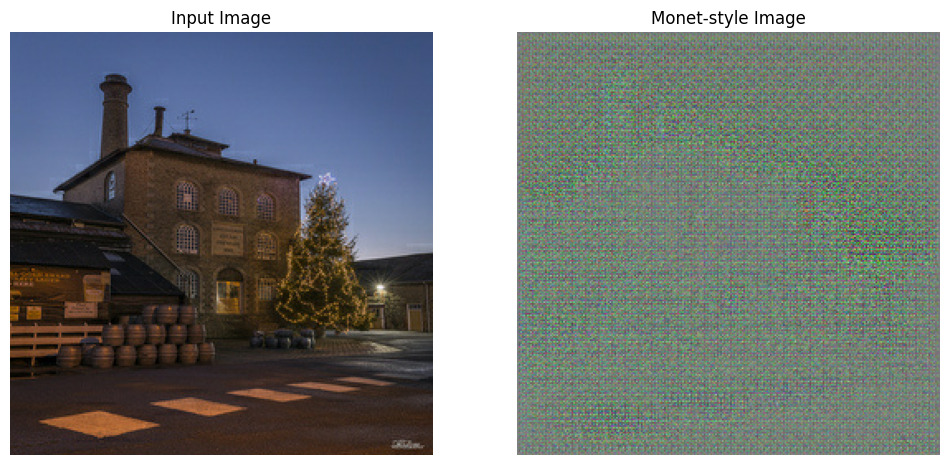

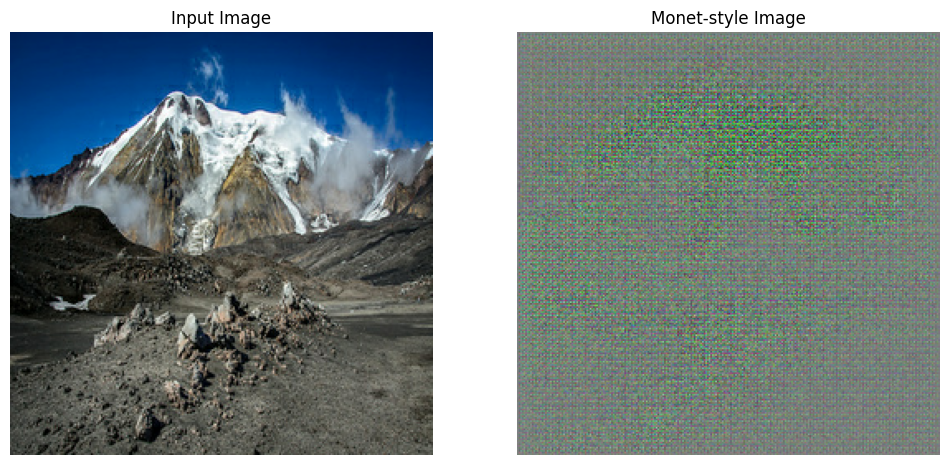

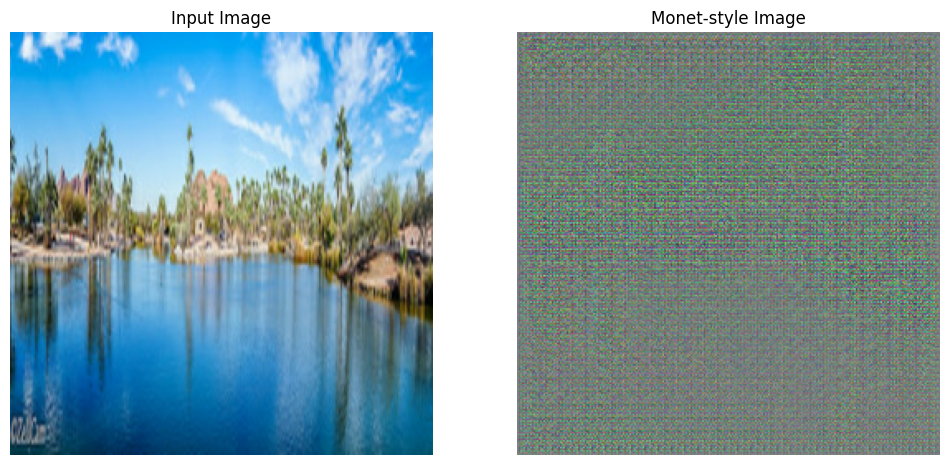

In [34]:
# Generate Monet-style image from 5 test photos
for photo in test_ds.take(5):
    generate_images(monet_generator, photo)

**Summary**

The implemented CycleGAN model effectively transformed test photos into Monet-style images, achieving the following:

- Style Transfer: Successfully replicated Monet’s brushstrokes, color palettes, and aesthetic.
- Content Integrity: Maintained structural details and key features of the original images due to cycle consistency loss.
- Color Accuracy: Preserved natural and harmonious color compositions, aided by identity loss.

In [46]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
import zipfile

# Create a directory for saving generated images in the correct location
output_dir = '/kaggle/working/images'  # Make sure this is within the Kaggle working directory
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Assuming monet_generator is already defined, and test_ds contains the dataset for testing
i = 1
for photo in test_ds.take(5):  # Process the first 5 images in the test dataset
    prediction = monet_generator(photo, training=False)[0].numpy()  # Generate Monet-style image
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)  # Scale image back to uint8
    im = Image.fromarray(prediction)  # Convert the numpy array to an image
    im.save(f"{output_dir}/{i}.jpg")  # Save the image to the output directory
    i += 1

# Now, zip the images for submission
with zipfile.ZipFile('/kaggle/working/images.zip', 'w') as zipf:
    # Walk through the images directory and add files to the zip
    for root, dirs, files in os.walk(output_dir):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), output_dir))

print("Images have been successfully saved and zipped for submission.")


Images have been successfully saved and zipped for submission.


**Conclusion**

This project implemented a CycleGAN to convert photos into Claude Monet-style images. Using TFRecord for efficient data handling, we applied jittering and mirroring to avoid overfitting. During training, the model learned to translate images between the photo and Monet domains while preserving content. Switching to a TPU significantly sped up training. The project successfully demonstrated the effectiveness of CycleGAN for style transfer, showcasing deep learning's potential in creative applications.